В цьому наборі завдань закріпимо те, що було на лекції з Computer Vision.

# Computer Vision with PyTorch Excercises. Solution


## 1. Наведіть 3 галузі промисловості, де комп'ютерний зір використовується сьогодні (можна згадати з лекції, або провести міні-рісерч).

# Today computer vision methods are used in various industries. Here just three examples:
- photo/video processing
- self-driving cars
- callories calculation apps

## 2. Виділіть 20 хвилин аби ознайомитись та переглянути сайт [CNN Explainer](https://poloclub.github.io/cnn-explainer/).

* Завантажте власне будь-яке зображення за допомогою кнопки Upload" на сайті та подивіться, що відбувається на кожному шарі CNN, коли ваше зображення проходить через нього.

Напишіть 3 пункти, що ви дізнались після цієї вправи?

From this exercize, I learned what layers does CNN contain. I've understood, that CNNs are basically consist of convolutional layers, ReLU layers and polling layers (Max pool in our case). CNN can consist of many these layers and the aim is to make data volume smaller and not to overfit the model.
In the end all data is transformed into single dimentional array in order to learn features and classify image data.

## 3. Завантажте навчальні та тестові набори даних [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST).

MNIST - базовий набір даних для задач Computer Vision. Часто використовується для навчання.

- Виведіть, скільки елементів в кожному наборі.
- Покажіть формат (розмірності) кожної картинки.
- Виведіть, які класи представлені в цьому наборі даних.

In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

print(
    f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False, # Get test data
    download=True,
    transform=ToTensor()
)


image, label = train_data[0]
classes = train_data.classes

print(f"Number of elements in train data: {len(train_data)}")
print(f"Image dimentions: {image.shape}")
print(f"Number of classes in train_data: {classes}")

PyTorch version: 2.7.0
torchvision version: 0.22.0
Number of elements in train data: 60000
Image dimentions: torch.Size([1, 28, 28])
Number of classes in train_data: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


## 4. Візуалізуйте щонайменше 5 різних зразків з навчального набору даних MNIST.

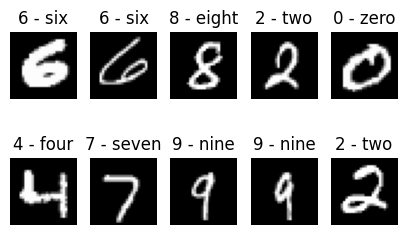

In [3]:
import matplotlib.pyplot as plt

torch.manual_seed(42)
fig = plt.figure(figsize=(5,3))
rows, cols = 2, 5

for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  
  plt.title(classes[label])
  plt.imshow(img.squeeze(), cmap="gray")
  plt.axis(False)

## 5. Перетворіть навчальні та тестові набори даних MNIST у data loaders за допомогою `torch.utils.data.DataLoader`, встановіть `batch_size=32`.
- Покажіть, яку форму даних вертають дата лоадери.

In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches {BATCH_SIZE} each")
print(f"Length of test dataloader: {len(test_dataloader)} batches {BATCH_SIZE} each")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x15e47a270>, <torch.utils.data.dataloader.DataLoader object at 0x15e2adbe0>)
Length of train dataloader: 3750 batches 16 each
Length of test dataloader: 625 batches 16 each


## 6. Відтворіть `ModelV2`, яку ми розглядали на лекції
Це до слова та сама модель з [сайту CNN Explainer](https://poloclub.github.io/cnn-explainer/), також відома як TinyVGG і вона здатна навчатися на наборі даних MNIST.

Напишіть клас моделі.

In [5]:
# This code snippet defines a PyTorch neural network model class named `MNISTModelV2` that implements an architecture inspired by TinyVGG. Here's a breakdown of what the code is doing:
class MNISTModelV2(nn.Module):
	"""
	Model architecture, which copies TinyVGG from:
	https://poloclub.github.io/cnn-explainer/
	"""
 
	def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
		super().__init__()
		self.block_1 = nn.Sequential(
			nn.Conv2d(
				in_channels=input_shape,
				out_channels=hidden_units,
				kernel_size=3, 				# shape of square, which explores an image
				stride=1,					# default value
				padding=1					
			),
			nn.ReLU(),
			nn.Conv2d(
				in_channels=hidden_units,
				out_channels=hidden_units,
				kernel_size=3,
				stride=1,
				padding=1
			),
   			nn.ReLU(),
			nn.MaxPool2d(
       			kernel_size=2,
                         stride=2
            )
		)
		self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
		self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did we take in_features form?
            # This is because each layer of our network squezes and changes form of input data
            nn.Linear(
                in_features=hidden_units*7*7,
                      out_features=output_shape
            )
        )
        
	def forward(self, x: torch.Tensor):
		x = self.block_1(x)
        # print(x.shape)
		x = self.block_2(x)
        # print(x.shape)
		x = self.classifier(x)
        # print(x.shape)
		return x

torch.manual_seed(42)
model = MNISTModelV2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(classes)).to('cpu')
model

MNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## 7. Навчіть модель, яку ви побудували в попередній вправі, протягом 5 епох на CPU та GPU і подивіться, скільки часу це займе в кожному з варіантів.

In [6]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn, 
               device: torch.device = 'cpu'
               ):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Loss calculation
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y) # Transformations from logits to forecasted labels
        
        # 3. Optimizer gradient nulling
        optimizer.zero_grad()
        
        # 4. Backwards loss pass
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
    # Losses and precision calculation for epoch and displaying results
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
def test_step(
    data_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = 'cpu'
    ):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # turn model into evaluation mode
    
    # Turn context manager on for inference
    
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to device
            X, y = X.to(device), y.to(device)
            
            # 1. Foward pass
            test_pred = model(X)
            
            # 2. Calculating losses adn precision
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y) # Transformations from logits to forecasted labels
			
        
        # Correcting metrics and displaying results
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
	"""Displays difference between start and end time

	Args:
		start (float): Start calculation time (preferebly in timeit format)
		end (float): End calculation time
		device (torch.device, optional): Calculation device. Defaults to None.

	Returns:
		_type_: _description_
	"""
 
	total_time = end - start
	print(f"Час навчання на {device}: {total_time:.3f} секунд")
	return total_time

In [7]:
# Імпорт метрики точності
import torchmetrics
accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(classes)).to('cpu')

# Налаштування функції втрат та оптимізатора
loss_fn = nn.CrossEntropyLoss() # це також називається "критерієм"/"функцією витрат" в деяких місцях
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

torch.manual_seed(42)

# Вимірювання часу
from timeit import default_timer as timer
train_time_start_on_cpu = timer()

from tqdm.auto import tqdm

epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_cpu = timer()
total_train_time_model = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device='cpu')

/Users/vitalijmatveev/Projects/data-loves-academy-machine-learning-for-people/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.24538 | Train accuracy: 0.92%


 20%|██        | 1/5 [00:37<02:28, 37.00s/it]

Test loss: 0.07742 | Test accuracy: 0.97%

Epoch: 1
---------
Train loss: 0.08678 | Train accuracy: 0.97%


 40%|████      | 2/5 [01:13<01:49, 36.65s/it]

Test loss: 0.06947 | Test accuracy: 0.98%

Epoch: 2
---------
Train loss: 0.06970 | Train accuracy: 0.98%


 60%|██████    | 3/5 [01:49<01:12, 36.41s/it]

Test loss: 0.05724 | Test accuracy: 0.98%

Epoch: 3
---------
Train loss: 0.06107 | Train accuracy: 0.98%


 80%|████████  | 4/5 [02:25<00:36, 36.31s/it]

Test loss: 0.05322 | Test accuracy: 0.98%

Epoch: 4
---------
Train loss: 0.05590 | Train accuracy: 0.98%


100%|██████████| 5/5 [03:02<00:00, 36.43s/it]

Test loss: 0.05495 | Test accuracy: 0.98%

Час навчання на cpu: 182.147 секунд


## 8. Зробіть прогнози за допомогою вашої навченої моделі та візуалізуйте принаймні 5 з них, порівнюючи прогноз з цільовою міткою.

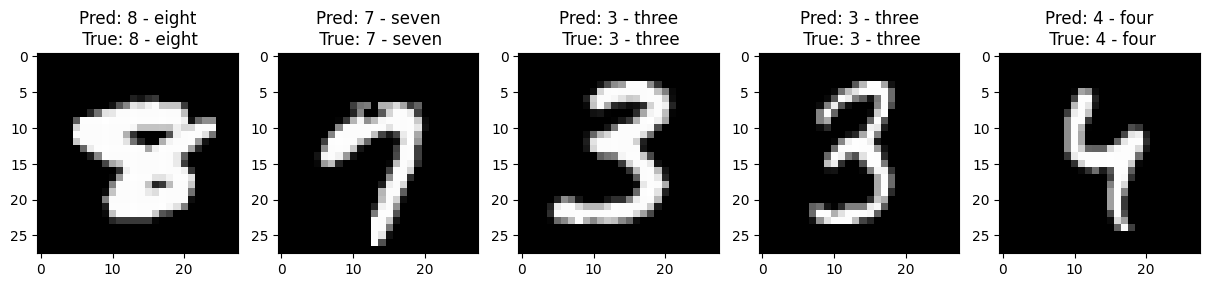

In [8]:
## Set model in evaluation mode and make sure that I am not tracking gradients 
# as this speeds up inference and saves memory.
model.eval()

## Fetch several samples from dataset
import random
num_samples = 5
samples = random.sample(range(len(test_data)), num_samples)

# For each sample, get the image and label, predict with the model and store the results
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

with torch.inference_mode():
    for idx, sample_idx in enumerate(samples):
        img, true_label = test_data[sample_idx]
        # Model expects batch, so unsqueze to add batch dimension
        img = img.unsqueeze(0)
        pred_logits = model(img)
        pred_label = pred_logits.argmax(dim=1).item()
        
        axes[idx].imshow(img.squeeze(), cmap="gray")
        axes[idx].set_title(f"Pred: {classes[pred_label]}\n True: {classes[true_label]}")

## 9. Побудуйте матрицю плутанини, порівнюючи передбачення вашої моделі з істинними мітками.

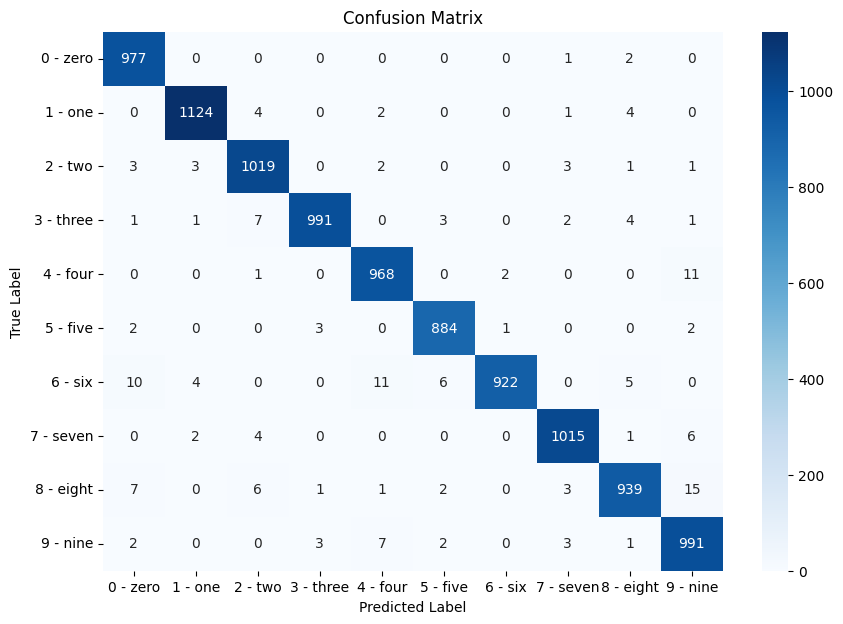

In [13]:
## Loop through test loader and collect the true labels and model predictions
all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        preds = model(X)
        preds = preds.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        
# Build Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,7))  # Optional: make the plot larger
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 10. Виведіть принаймні 9 прикладів, де модель помиляється, разом з тим, якою мала бути мітка зображення.
* Після візуалізації цих прогнозів, як ви думаєте, це більше помилка моделювання чи помилка даних?
* Тобто, чи може модель працювати краще, чи мітки даних занадто близькі одна до одної, що навіть людина не може чітко розрізнити що це за цифра?

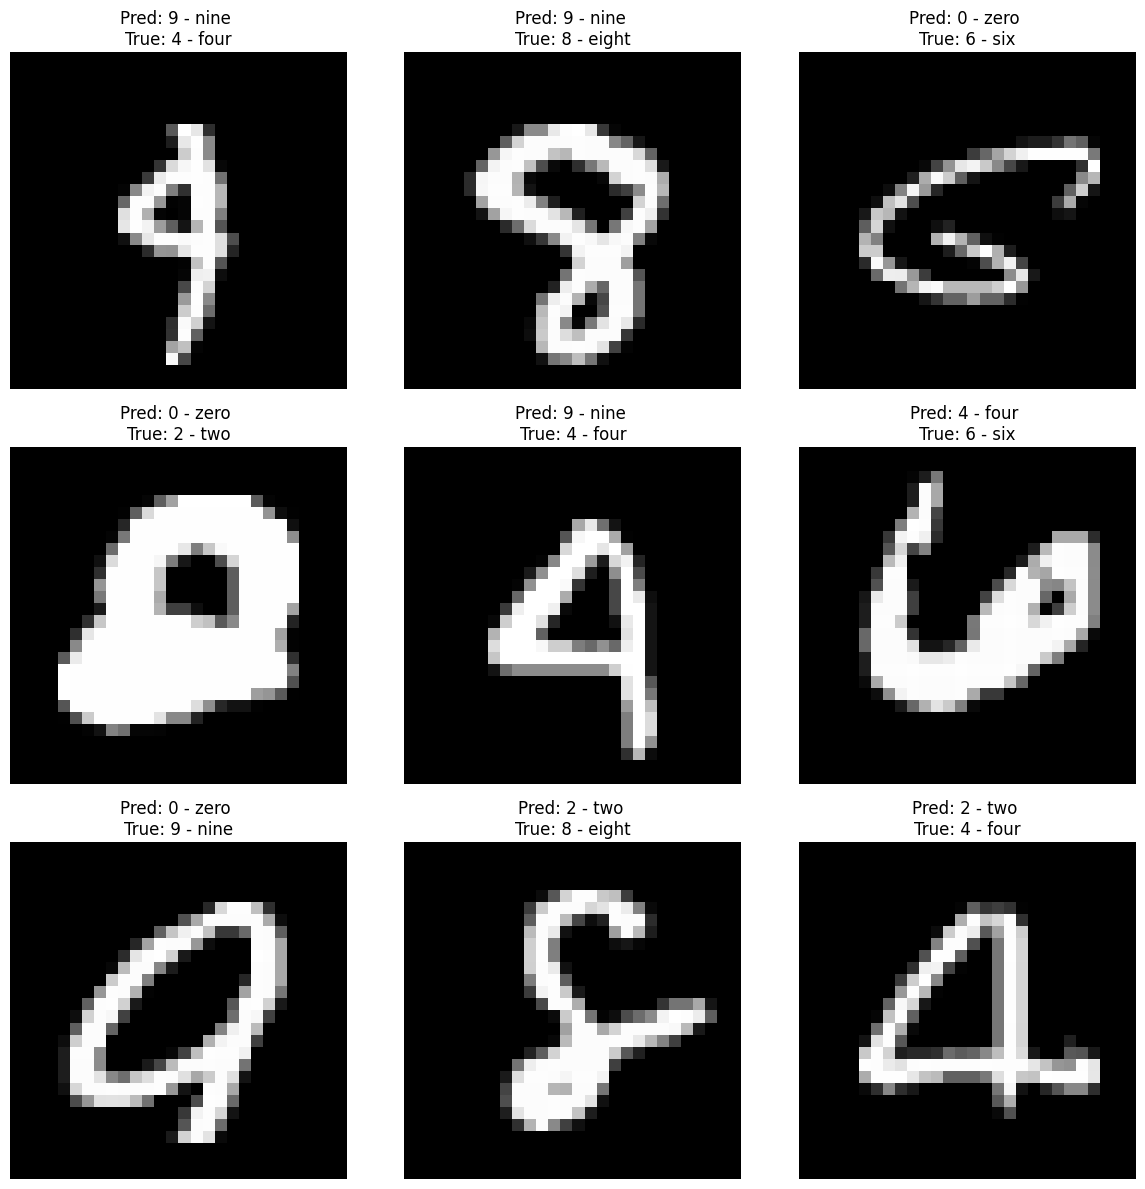

In [15]:
# Get all examples where model prediction did not match true label

wrong_examples = []

model.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        preds = model(X)
        preds_labels = preds.argmax(dim=1)
        for img, pred, true in zip(X, preds_labels, y):
            if pred != true:
                wrong_examples.append((img, pred.item(), true.item()))
                
# Plot 9 of examples with predicted and actual label
import matplotlib.pyplot as plt

num_to_show = 9
plt.figure(figsize=(12, 12))
for idx, (img, pred, true) in enumerate(wrong_examples[:num_to_show]):
    plt.subplot(3, 3, idx+1)
    plt.imshow(img.squeeze(), cmap='grey')
    plt.title(f"Pred: {classes[pred]} \nTrue: {classes[true]}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

I would say, that this errors occured because numbers are not very readable and even human can make mistakes.

## 11. Створіть випадковий тензор форми `[1, 3, 64, 64]` і пропустіть його через шар `nn.Conv2d()` з різними налаштуваннями гіперпараметрів (ви можете вибрати будь-які налаштування), що ви помічаєте, якщо параметр `kernel_size` збільшується або зменшується?

In [ ]:
import torch 

x = torch.rand(1, 3, 64, 64)
print(x.shape)

print("\nWithout Padding:")
for k in [1, 3, 5, 7, 15]:
	conv = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=k)
	y = conv(x)
	print(f"Kernel size {k}: output shape {y.shape}")


print("\nWith Padding:")
for k in [1, 3, 5, 7, 15]:
	conv = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=k, padding='same')
	y = conv(x)
	print(f"Kernel size {k}: output shape {y.shape}")

torch.Size([1, 3, 64, 64])

Without Padding:
Kernel size 1: output shape torch.Size([1, 8, 64, 64])
Kernel size 3: output shape torch.Size([1, 8, 62, 62])
Kernel size 5: output shape torch.Size([1, 8, 60, 60])
Kernel size 7: output shape torch.Size([1, 8, 58, 58])
Kernel size 15: output shape torch.Size([1, 8, 50, 50])

With Padding:
Kernel size 1: output shape torch.Size([1, 8, 64, 64])
Kernel size 3: output shape torch.Size([1, 8, 64, 64])
Kernel size 5: output shape torch.Size([1, 8, 64, 64])
Kernel size 7: output shape torch.Size([1, 8, 64, 64])
Kernel size 15: output shape torch.Size([1, 8, 64, 64])


As we can see, when kernel_size parameter increases output feature map gets smaller.
It happens because kernel "iterates through" border pixels and output shrinks.

In order to avoid this we can use padding formula as in second for loop using padding='same' parameter